# JSL109_01 (CF-900)

In [78]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [98]:
## Preparing some stuff
# Libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib, json, codecs, scipy, scipy.constants
import matplotlib.pyplot as plt
import scipy.stats
from IPython.core.display import display, HTML
import mjsplot as mplt

# Display
# display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

# Physical constants
e = scipy.constants.e
k_B = scipy.constants.Boltzmann
h = scipy.constants.h
Rk = h/e**2
Phi_0 = h/e # Flux quantum

# Load data
d = {}
df = {}
def loadin(filename): # a way to load in many different files and keep track of them. 
    datafile = json.loads( codecs.open('../data/'+filename,'r','utf-8').read() )
    key = datafile['attr']['_file counter']
    d[key]= datafile
    df[key] = pd.DataFrame(datafile['data']) 

# Find best matching filling factors
def find_nu(Bsdh):
    nu = np.linspace(20,1,20)
    Bnu_diff = [t/s for s, t in zip(1/nu, 1/nu[1:])]
    Bsdh_diff = np.array([t/s for s, t in zip(Bsdh, Bsdh[1:])])
    size_part = len(Bsdh_diff)
    residuals = [np.sum(Bnu_diff[i:i+size_part]-Bsdh_diff) for i in range(len(Bnu_diff)-size_part+1)]
    idx = np.argmin(np.abs(residuals))
    return nu[idx:idx+len(Bsdh)]

# Hallbar 1

## Density and mobility as a function of gate

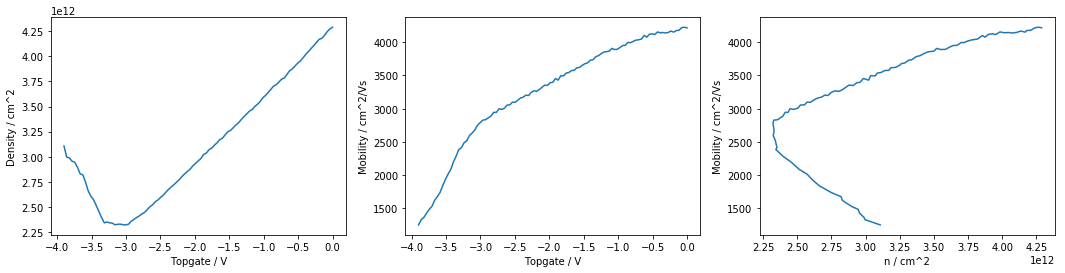

In [77]:
## Load data (not corrected for geometry)
loadin("20180607T143944320Z-0102.json")

# Get density
r_df_1  = pd.DataFrame()
dc_current = 1e-7
for label,group in df['0102'].groupby('Topgate Voltage / V'):
    [b,a] = np.polyfit(group['Magnet Z / T'],-group['DC Voltage 2 / A']/dc_current,1)
    Vxx = group[group['Magnet Z / T'] == 0.]['AC Voltage / V'].values[0]
    r_df_1 = r_df_1.append({'a':a,'b':b,'n':1/(e*b)*1e-4,'v':label,'Vxx':Vxx},ignore_index=True)
# Get mobility
r_df_1['rho'] = r_df_1['Vxx']/(1e-9 * 4) # 4 squares, 1e-9 AC Ibias
r_df_1['mu'] = 1/(r_df_1['rho']*r_df_1['n']*e)

## Plot
fig_1a, ax_1a = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

subplots_1a = [(r_df_1['v'],r_df_1['n']),(r_df_1['v'],r_df_1['mu']),(r_df_1['n'],r_df_1['mu'])]
labels_1a = [['Topgate / V','Density / cm^2'],['Topgate / V', 'Mobility / cm^2/Vs'], ['n / cm^2','Mobility / cm^2/Vs']]

for col,subplot,label in zip(ax_1a,subplots_1a,labels_1a):
    col.plot(*subplot)
    col.set_xlabel(label[0])
    col.set_ylabel(label[1])

# Save figure
fig_1a.savefig('../plots/hallbar1_mobilty_density.png')

## Data at Vgate = 0

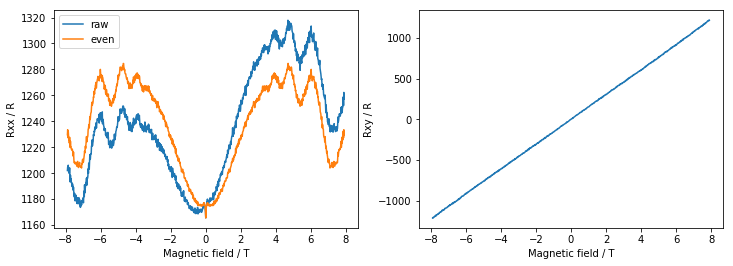

In [65]:
## Load data
loadin("20180605T200900927Z-0033.json")

Rxx = df['0033']['DC Voltage 1 / V'][:20279]/1e-7
Rxy = (-df['0033']['DC Voltage 2 / V'][:20279]+2.829e-4)/1e-7
Bmeas = df['0033']['Measured Field / T'][:20279]

fxx = sp.interpolate.interp1d(Bmeas,Rxx)
fxy = sp.interpolate.interp1d(Bmeas,Rxy)
B = np.linspace(-7.9,7.9,1001)
# Split even and odd parts (to correct of geometry effects)
fxx_even = (fxx(B)+fxx(-B))/2
fxy_odd = (fxx(B)-fxx(-B))/2

## Plot
fig_1b, ax_1b = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax_1b[0].plot(B,fxx(B),label='raw')
ax_1b[0].plot(B,fxx_even,label='even')
ax_1b[0].legend(loc='upper left')
ax_1b[1].plot(B,fxy(B))

for col,ylbl in zip(ax_1b,['Rxx / R','Rxy / R']):
    col.set_xlabel('Magnetic field / T')
    col.set_ylabel(ylbl)
    
# Save figure
plt.savefig('../plots/hallbar1_rxx_rxy.png')

## Extract single subband

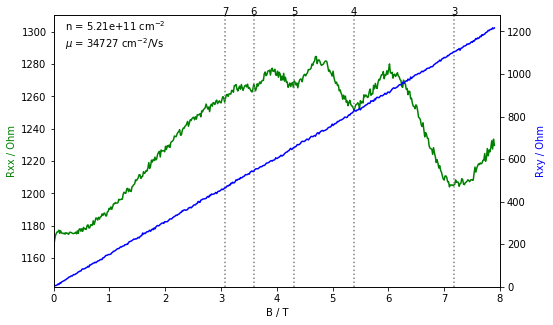

In [71]:
## Filling factors
Bsdh = np.array([3.1,3.6,4.3,5.3,7.23]) # Shubnikov- de Haas minima from Rxy

# Find best matching filling factors
nu = find_nu(Bsdh)
n = np.mean(Bsdh*nu/Phi_0)*1e-4
mu = 1/(r_df_1[r_df_1['v'] == 0.]['rho'].values[0] * n * e)
B_nu = n*1e4*Phi_0/nu

# Make overview plot
fig_1c, ax_1c = plt.subplots(figsize=(8,5))
xmax = [min(fxx_even)*0.98,0]
ymax = [max(fxx_even)*1.02,fxy(B)[-1]*1.05]
for ax,ylims,f,color,label in zip([ax_1c,ax_1c.twinx()],
                    [(xmax[0],ymax[0]),(xmax[1],ymax[1])],
                    [fxx_even,fxy(B)],['green','blue'],
                    ['Rxx / Ohm','Rxy / Ohm']):
    ax.set_xlim(0,8)
    ax.set_ylim(*ylims)
    ax.plot(B,f,color=color)
    ax.set_xlabel('B / T')
    ax.set_ylabel(label,color=color)

# Density and mobility annotation
ax_1c.annotate('n = {0:.2e} '.format(n)+u'cm$^{-2}$',(0.2,ymax[0]-10))
ax_1c.annotate(u'${\mu}$'+' = {0:.0f} '.format(mu)+u'cm$^{-2}$/Vs',(0.2,ymax[0]-20))

# Filling factors
for xc,nuc in zip(B_nu,nu):
    ax_1c.axvline(x=xc,color='gray',ls=':')
    ax_1c.annotate('{0:.0f}'.format(nuc),(xc,ymax[0]),ha="center")
    
# Save figure
fig_1c.savefig('../plots/hallbar1_overview.png')

# Hallbar 3

## Density and mobility as a function of gate

### Magnetic field up to 8T

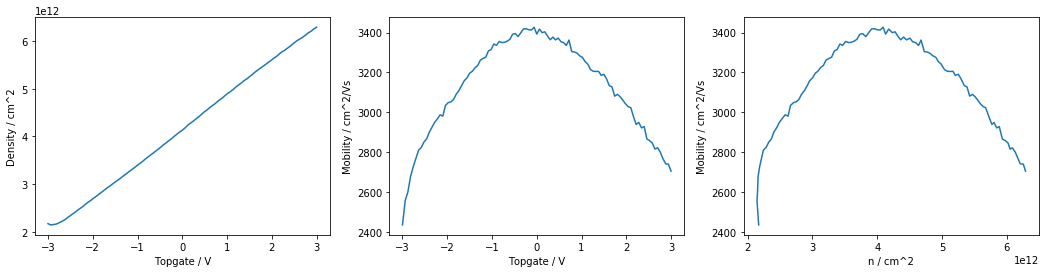

In [2]:
## Load data (not corrected for geometry)
loadin("20180613T113051881Z-0148.json")

# Get density
r_df_3  = pd.DataFrame()
dc_current = 1e-7
for label,group in df['0148'].groupby('Topgate Voltage / V'):
    [b,a] = np.polyfit(group['Magnet Z / T'],group['DC Voltage xy / V']/dc_current,1)
    Vxx = group[group['Magnet Z / T'] == 0.]['AC Voltage xx / V'].values[0]
    r_df_3 = r_df_3.append({'a':a,'b':b,'n':1/(e*b)*1e-4,'v':label,'Vxx':Vxx},ignore_index=True)
# Get mobility
r_df_3['rho'] = r_df_3['Vxx']/(1e-9 * 4) # 4 squares, 1e-9 AC Ibias
r_df_3['mu'] = 1/(r_df_3['rho']*r_df_3['n']*e)

## Plot
fig_3a, ax_3a = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

subplots_3a = [(r_df_3['v'],r_df_3['n']),(r_df_3['v'],r_df_3['mu']),(r_df_3['n'],r_df_3['mu'])]
labels_3a = [['Topgate / V','Density / cm^2'],['Topgate / V', 'Mobility / cm^2/Vs'], ['n / cm^2','Mobility / cm^2/Vs']]

for col,subplot,label in zip(ax_3a,subplots_3a,labels_3a):
    col.plot(*subplot)
    col.set_xlabel(label[0])
    col.set_ylabel(label[1])

# Save figure
fig_3a.savefig('../plots/hallbar3_mobilty_density.png')

### Magnetic field up to 9T and long Lockin integration

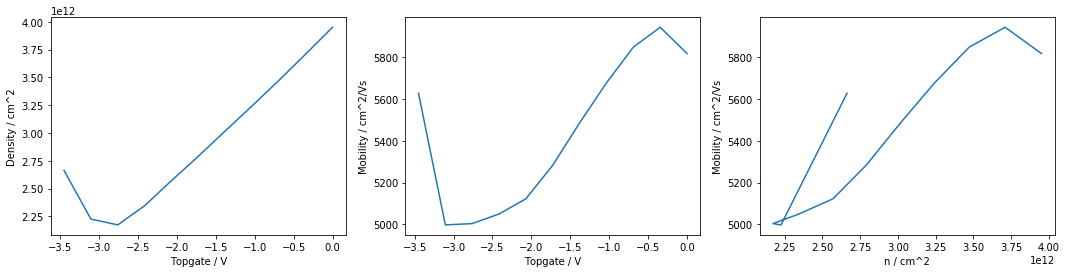

In [4]:
## Load data (not corrected for geometry)
loadin("20180615T151142115Z-0179.json")

# Get density
r_df_3  = pd.DataFrame()
dc_current = 1e-7
for label,group in df['0179'].groupby('Topgate Voltage / V'):
    [b,a] = np.polyfit(group['Magnet Z / T'],group['DC Voltage xy / V']/dc_current,1)
    Vxx = group[group['Magnet Z / T'] == 0.]['AC Voltage xx / V'].values[0]
    r_df_3 = r_df_3.append({'a':a,'b':b,'n':1/(e*b)*1e-4,'v':label,'Vxx':Vxx},ignore_index=True)
# Get mobility
r_df_3['rho'] = r_df_3['Vxx']/(1e-9 * 4) # 4 squares, 1e-9 AC Ibias
r_df_3['mu'] = 1/(r_df_3['rho']*r_df_3['n']*e)

## Plot
fig_3a, ax_3a = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

subplots_3a = [(r_df_3['v'],r_df_3['n']),(r_df_3['v'],r_df_3['mu']),(r_df_3['n'],r_df_3['mu'])]
labels_3a = [['Topgate / V','Density / cm^2'],['Topgate / V', 'Mobility / cm^2/Vs'], ['n / cm^2','Mobility / cm^2/Vs']]

for col,subplot,label in zip(ax_3a,subplots_3a,labels_3a):
    col.plot(*subplot)
    col.set_xlabel(label[0])
    col.set_ylabel(label[1])

# Save figure
fig_3a.savefig('../plots/hallbar3_mobilty_density.png')

## Raw data at Vgate = 0

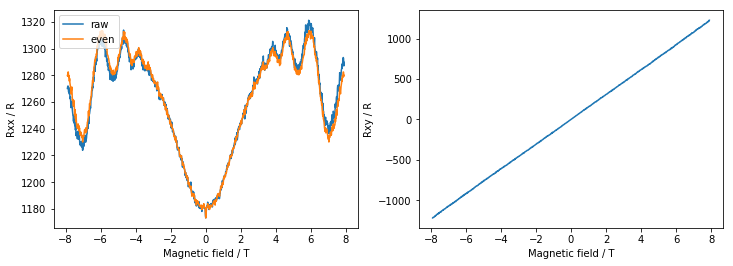

In [6]:
## Load data
loadin("20180612T154100712Z-0133.json")

Rxx = df['0133']['DC Voltage xx / V'][4670:13977]/1e-7
Rxy = (df['0133']['DC Voltage xy / V'][4670:13977]+6.55803e-5)/1e-7
Bmeas = df['0133']['Measured Field / T'][4670:13977]

fxx = sp.interpolate.interp1d(Bmeas,Rxx)
fxy = sp.interpolate.interp1d(Bmeas,Rxy)
B = np.linspace(-7.9,7.9,1001)
# Split even and odd parts (to correct of geometry effects)
fxx_even = (fxx(B)+fxx(-B))/2
fxy_odd = (fxx(B)-fxx(-B))/2

## Plot
fig_3b, ax_3b = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax_3b[0].plot(B,fxx(B),label='raw')
ax_3b[0].plot(B,fxx_even,label='even')
ax_3b[0].legend(loc='upper left')
ax_3b[1].plot(B,fxy(B))

for col,ylbl in zip(ax_3b,['Rxx / R','Rxy / R']):
    col.set_xlabel('Magnetic field / T')
    col.set_ylabel(ylbl)

fig_3b.savefig('../plots/hallbar3_rxx_rxy.png')

## Extract single subband

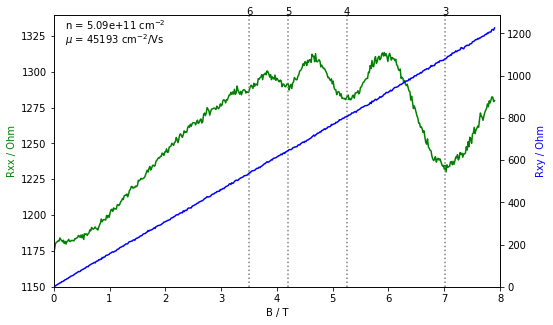

In [7]:
## Filling factors
Bsdh = np.array([3.5,4.2,5.25,7.05]) # Shubnikov- de Haas minima from Rxy

# Find best matching filling factors
nu = find_nu(Bsdh)
n = np.mean(Bsdh*nu/Phi_0)*1e-4
mu = 1/(r_df_3[r_df_3['v'] == 0.]['rho'].values[0] * n * e)
B_nu = n*1e4*Phi_0/nu

# Make overview plot
fig_3c, ax_3c = plt.subplots(figsize=(8,5))
xmax = [min(fxx_even)*0.98,0]
ymax = [max(fxx_even)*1.02,fxy(B)[-1]*1.05]
for ax,ylims,f,color,label in zip([ax_3c,ax_3c.twinx()],
                    [(xmax[0],ymax[0]),(xmax[1],ymax[1])],
                    [fxx_even,fxy(B)],['green','blue'],
                    ['Rxx / Ohm','Rxy / Ohm']):
    ax.set_xlim(0,8)
    ax.set_ylim(*ylims)
    ax.plot(B,f,color=color)
    ax.set_xlabel('B / T')
    ax.set_ylabel(label,color=color)

# Density and mobility annotation
ax_3c.annotate('n = {0:.2e} '.format(n)+u'cm$^{-2}$',(0.2,ymax[0]-10))
ax_3c.annotate(u'${\mu}$'+' = {0:.0f} '.format(mu)+u'cm$^{-2}$/Vs',(0.2,ymax[0]-20))

# Filling factors
for xc,nuc in zip(B_nu,nu):
    ax_3c.axvline(x=xc,color='gray',ls=':')
    ax_3c.annotate('{0:.0f}'.format(nuc),(xc,ymax[0]),ha="center")
    
# Save figure
fig_3c.savefig('../plots/hallbar3_overview.png')

## Track subband densities with gate

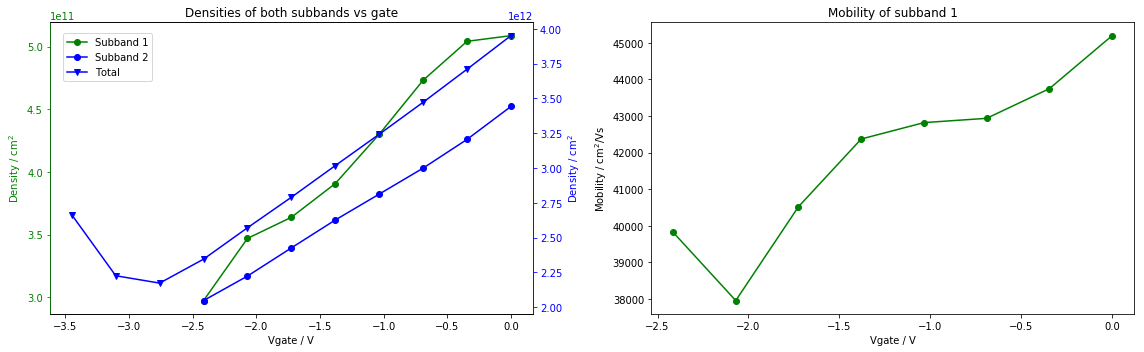

In [107]:
Bsdh_all = {}
Bsdh_all[0] = [3.5,4.2,5.25,7.05]
Bsdh_all[-0.345] = [4.15,5.2,7]
Bsdh_all[-0.69] = [3.85,4.95,6.55]
Bsdh_all[-1.035] = [3.57,4.58,6.03,8.44]
Bsdh_all[-1.38] = [4.01,5.5,7.97]
Bsdh_all[-1.7249999999999999] = [3.76,5.1,7.4]
Bsdh_all[-2.07] = [4.9,7]
Bsdh_all[-2.415] = [4.1,6.15]

# Get density from Rxx data (single channel)
n_band1, mu_band1, nu_band1 = [],[],[]
for vgate,Bsdh in Bsdh_all.items():
    # Find best matching filling factors
    nu = find_nu(Bsdh)
    n = np.mean(Bsdh*nu/Phi_0)*1e-4 
    mu = 1/(r_df_3[r_df_3['v'] == vgate]['rho'].values[0] * n * e)
    nu_band1.append(nu)
    n_band1.append(n)
    mu_band1.append(mu)
    
# Get densities from Rxy data (all channels combined) 
v_rem = [r_df_3[r_df_3['v'] == vgate]['v'].values[0] for vgate,_ in Bsdh_all.items()]  
n_rem = [r_df_3[r_df_3['v'] == vgate]['n'].values[0] for vgate,_ in Bsdh_all.items()]

# Plot both channels as a function of gate
fig_3d, ax_3d = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
ax_3dr = ax_3d[0].twinx()
for axes,plot,label,ls,color in zip([ax_3d[0],ax_3dr,ax_3dr],
                                     [([vgate for vgate,_ in Bsdh_all.items()],n_band1),(v_rem,np.array(n_rem)-np.array(n_band1)),(r_df_3['v'],r_df_3['n'])],
                                     ['Subband 1','Subband 2','Total'],
                                     ['o-','o-','v-'],
                                     ['green','blue','blue']):
    axes.plot(*plot,ls,label=label,color=color)
    axes.set_ylabel(u'Density / cm$^{2}$',color=color)
    axes.set_xlabel('Vgate / V')
    axes.yaxis.label.set_color(color)
    axes.tick_params(axis='y', colors=color)
    axes.spines['right'].set_edgecolor(color)
ax_3d[0].set_title('Densities of both subbands vs gate')
fig_3d.legend(loc='upper left', bbox_to_anchor=(0.05,0.9))
ax_3dr.spines['left'].set_edgecolor('green')

# Plot mobility
ax_3d[1].plot([vgate for vgate,_ in Bsdh_all.items()],mu_band1,'o-',color='green')
ax_3d[1].set_xlabel('Vgate / V')
ax_3d[1].set_ylabel(u'Mobility / cm$^{2}$/Vs')
ax_3d[1].set_title('Mobility of subband 1')
fig_3d.tight_layout()

# Save figure
fig_3d.savefig('../plots/hallbar3_subbands.png')

# Hallbar 4

## Density and mobility as a function of gate

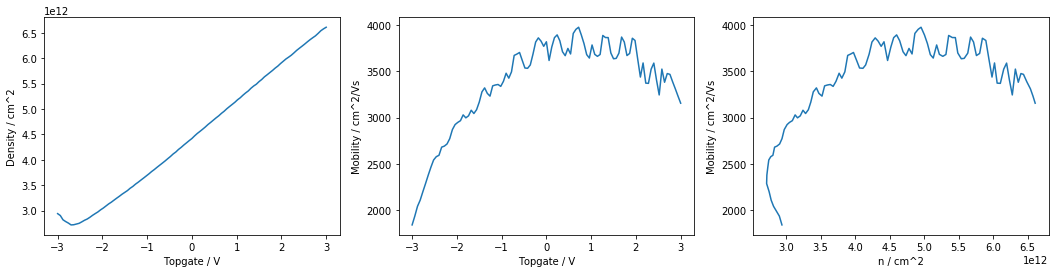

In [18]:
## Load data (not corrected for geometry)
loadin("20180613T155326468Z-0150.json")

# Get density
r_df_4  = pd.DataFrame()
dc_current = 1e-7
for label,group in df['0150'].groupby('Topgate Voltage / V'):
    [b,a] = np.polyfit(group['Magnet Z / T'],group['DC Voltage xy / V']/dc_current,1)
    Vxx = group[group['Magnet Z / T'] == 0.]['AC Voltage xx / V'].values[0]
    r_df_4 = r_df_4.append({'a':a,'b':b,'n':1/(e*b)*1e-4,'v':label,'Vxx':Vxx},ignore_index=True)
# Get mobility
r_df_4['rho'] = r_df_4['Vxx']/(dc_current*0.01 * 2) # 2 squares, 1V LI -> AC Ibias = 0.01 DC Ibias
r_df_4['mu'] = 1/(r_df_4['rho']*r_df_4['n']*e)

## Plot
fig_1a, ax_1a = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

subplots_1a = [(r_df_4['v'],r_df_4['n']),(r_df_4['v'],r_df_4['mu']),(r_df_4['n'],r_df_4['mu'])]
labels_1a = [['Topgate / V','Density / cm^2'],['Topgate / V', 'Mobility / cm^2/Vs'], ['n / cm^2','Mobility / cm^2/Vs']]

for col,subplot,label in zip(ax_1a,subplots_1a,labels_1a):
    col.plot(*subplot)
    col.set_xlabel(label[0])
    col.set_ylabel(label[1])

# Save figure
fig_1a.savefig('../plots/hallbar4_mobilty_density.png')

## Raw data at Vgate = 0

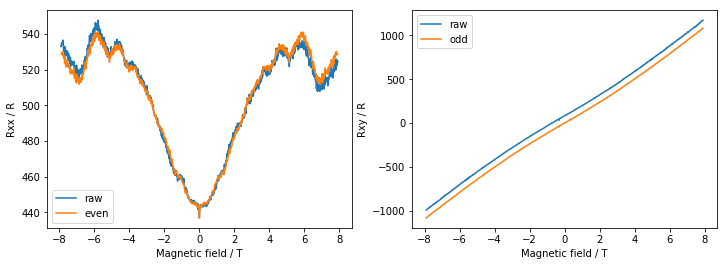

In [19]:
## Load data
loadin("20180613T195056559Z-0151.json")

Rxx = df['0151']['DC Voltage xx / V'][:5851]/1e-7
Rxy = (df['0151']['DC Voltage xy / V'][:5851]+7.3e-5)/1e-7
Bmeas = df['0151']['Measured Field / T'][:5851]

fxx = sp.interpolate.interp1d(Bmeas,Rxx)
fxy = sp.interpolate.interp1d(Bmeas,Rxy)
B = np.linspace(-7.9,7.9,1001)
# Split even and odd parts (to correct of geometry effects)
fxx_even = (fxx(B)+fxx(-B))/2
fxy_odd = (fxy(B)-fxy(-B))/2

## Plot
fig_1b, ax_1b = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax_1b[0].plot(B,fxx(B),label='raw')
ax_1b[0].plot(B,fxx_even,label='even')
ax_1b[0].legend(loc='lower left')
ax_1b[1].plot(B,fxy(B),label='raw')
ax_1b[1].plot(B,fxy_odd,label='odd')
ax_1b[1].legend(loc='upper left')

for col,ylbl in zip(ax_1b,['Rxx / R','Rxy / R']):
    col.set_xlabel('Magnetic field / T')
    col.set_ylabel(ylbl)

plt.savefig('../plots/hallbar4_rxx_rxy.png')

## Extract single subband

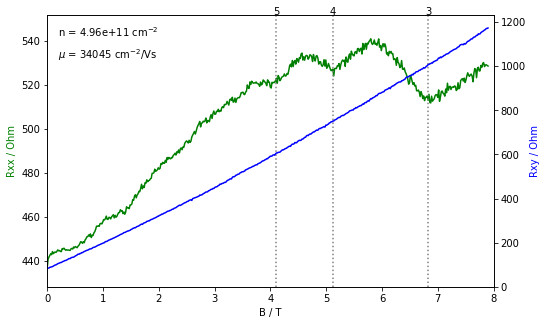

In [54]:
## Filling factors
Bsdh = np.array([4.1,5,7]) # Shubnikov- de Haas minima from Rxy

# Find best matching filling factors
nu = find_nu(Bsdh)
n = np.mean(Bsdh*nu/Phi_0)*1e-4
mu = 1/(r_df_4[r_df_4['v'] == 0.]['rho'].values[0] * n * e)
B_nu = n*1e4*Phi_0/nu

# Make overview plot
fig_4c, ax_4c = plt.subplots(figsize=(8,5))
xmax = [min(fxx_even)*0.98,0]
ymax = [max(fxx_even)*1.02,fxy(B[-1])*1.05]
for ax,ylims,f,color,label in zip([ax_4c,ax_4c.twinx()],
                    [(xmax[0],ymax[0]),(xmax[1],ymax[1])],
                    [fxx_even,fxy(B)],['green','blue'],
                    ['Rxx / Ohm','Rxy / Ohm']):
    ax.set_xlim(0,8)
    ax.set_ylim(*ylims)
    ax.plot(B,f,color=color)
    ax.set_xlabel('B / T')
    ax.set_ylabel(label,color=color)

# Density and mobility annotation
ax_4c.annotate('n = {0:.2e} '.format(n)+u'cm$^{-2}$',(0.2,ymax[0]-10))
ax_4c.annotate(u'${\mu}$'+' = {0:.0f} '.format(mu)+u'cm$^{-2}$/Vs',(0.2,ymax[0]-20))

# Filling factors
for xc,nuc in zip(B_nu,nu):
    ax_4c.axvline(x=xc,color='gray',ls=':')
    ax_4c.annotate('{0:.0f}'.format(nuc),(xc,ymax[0]),ha="center")
    
# Save figure
fig_4c.savefig('../plots/hallbar4_overview.png')